# 2.3 Curry-Howard correspondence

![haskell](../images/haskellcurry.jpeg) Haskell Brooks Curry

![howard](../images/howard-resize.jpg)Willian Howard

In this notebook we deal with another striking connection between functional programming and, in principle, a completely unrelated field of knowledge. When algebraic data types were introduced, we established a strong connection with _arithmetics_: now, it's the turn of _logic_. We will see that functional programming is akin, in a very close sense, to doing logic. That, when we write a type signature we are writing propositions that have to be proved; and that when we implement that signature, we are actually providing a proof of that proposition. Thus, this notebook resolves to show the following correspondences:

$$
\begin{array}{cc}
\mathrm{\bf Computation} & \mathrm{\bf Logic} \\
\hline 
\mathrm{Programs} & \mathrm{Proofs} \\
\mathrm{Types} & \mathrm{Propositions} 
\end{array}
$$

This correspondence between logic and computation is known as the Curry-Howard correspondence. It shows that programming functionally and following the laws of logic is the very same thing, ... and who on earth would want to program in a different way!

### References

[__The Curry-Howard correspondence__](https://en.wikipedia.org/wiki/Curry%E2%80%93Howard_correspondence) Wikpedia. 

[__Propositions as types__](https://homepages.inf.ed.ac.uk/wadler/papers/propositions-as-types/propositions-as-types.pdf). Philip Wadler. 

[__Intuitionistic logic__](https://en.wikipedia.org/wiki/Intuitionistic_logic). Wikipedia.

# A refresher: arithmetic and types

Recall the correspondence between algebraic data types and arithmetic operators: 

$$ 
\begin{array}{cc}
\mathrm{\bf Scala\ ADTs} & \mathrm{\bf Arithmetic} \\
\hline
\mathtt{Unit} & 1 \\
\mathtt{Nothing} & 0 \\
\mathtt{Either[X, Y]} & x + y \\
\mathtt{(X, Y)} & x * y \\
\mathtt{X => Y} & {y^x}  
\end{array}
$$

According to this algebraic interpretation of types, the type 

In [ ]:
type A = (Unit, Either[Unit, (Boolean => Either[Unit, Unit])])

has exactly `1*(1+(1+1)^2)` values. But not only that: corresponding to the equality `1*(1+(1+1)^2)=5`, the following isomorphism holds: 

In [ ]:
def from(a: A): Either[Unit, Either[Unit, Either[Unit, Either[Unit, Unit]]]] = ???

def to(a: Either[Unit, Either[Unit, Either[Unit, Either[Unit, Unit]]]]): A = ???

# Propositions as types

We put forward now the following correspondence: 

$$ 
\begin{array}{cc}
\mathrm{\bf Scala\ ADTs} & \mathrm{\bf Logic} \\
\hline
\mathtt{Unit} & \top \\
\mathtt{Nothing} & \bot \\
\mathtt{Either[P, Q]} & p \vee q \\
\mathtt{(P, Q)} & p \wedge q \\
\mathtt{P => Q} & p \rightarrow q 
\end{array}
$$


so that, for instance, the following type:

```scala
(P => Q, P) => Q
```

corresponds to the following formula of propositional logic: 

$\hspace{0.8cm}(p \rightarrow q) \wedge p \rightarrow q$

Let's get used to read Scala types as propositional formulas with these examples: 

$$
\begin{array}{cc}
\mathrm{\bf Scala\ types} & \mathrm{\bf Propositions} \\
\hline
\mathtt{(P, Either[Q, R])} & p \wedge (q\vee r) \\ 
\mathtt{P => Q => (Q, R)} & p \rightarrow q \rightarrow q \wedge r \\
\mathtt{(P => Nothing) => Nothing} & (p \rightarrow \bot) \rightarrow \bot \\ 
\end{array}
$$

What about logical negation and equivalence? They are commonly regarded as abbreviations: 

* $\neg p$ abbreviates $p \rightarrow \bot$ (i.e. if we assume $p$, we reach a contradiction)
* $p \leftrightarrow q$ abbreviates $p \rightarrow q \wedge q \rightarrow p$ 

so, they will be represented in Scala through the following type aliases: 

In [ ]:
type Not[P] = P => Nothing
type <=>[P, Q] = (P => Q, Q => P)

Let's translate the following propositional formulas to Scala types: 


$$ 
\begin{array}{cc}
\mathrm{\bf Logic} & \mathrm{\bf Scala\ ADTs} \\
\hline
(p \wedge q \rightarrow r) \leftrightarrow (p \rightarrow q \rightarrow r) & \mathtt{(((P,Q)) => R) <=> (P => Q => R)} \\
\neg (p \wedge q) \rightarrow \neg p \vee \neg q & \mathtt{Not[(P, Q)] => Either[Not[P], Not[Q]]}\\
\neg\neg(p \vee \neg p) & \mathtt{Not[Not[Either[P, Not[P]]]]}\\
p \vee (q \wedge r) \leftrightarrow (p \vee q) \wedge (p \vee r) & 
\mathtt{Either[P, (Q, R)] <=> (Either[P, Q], Either[P, R])}
\end{array}
$$


Note that $p \wedge q \rightarrow r$ translates to `((P,Q)) => R`, and not to `(P, Q) => R`. The former is a `Function1` which receives a single argument of tuple type `(P, Q)`; the latter is a `Function2` which receives two arguments of types `P` and `Q`. 

# Proofs as programs

Right, but this is just a syntactic rewriting. In which sense, for instance, the Scala type

`(P, Either[Q, R]) => Either[(P, Q), (P, R)]`

is a proper counterpart of the proposition
$p \wedge (q \vee r) \rightarrow p \wedge q \vee p \wedge r$? The answer is that they behave exactly in the same way: we can implement a program (expression or term) of that type if, and only if, the corresponding proposition is a theorem. Thus, the program is a witness that the proposition can be proved; in fact, we can automatically obtained a proof from that program, and viceversa. Let's start from a possible program:



In [ ]:
def program[P, Q, R]: ((P, Either[Q, R])) => Either[(P, Q), (P, R)] = 
    {
        case (p, Left(q)) => Left((p, q))
        case (p, Right(r)) => Right((p, r))
    }

How is this program related to a proof of $p \wedge (q \vee r) \rightarrow p \wedge q \vee p \wedge r$? In order to talk about proofs we need a formal system, and our proof system of choice is Gentzen's natural deduction system. These are its introduction and elimination rules: 

![natural deduction rules](../images/natdedrules.png)

Now, we can give a proof as follows:

$$
\begin{array}{llr}
1     & p \wedge (q \vee r) & premise \\
1.1   & p  & \wedge E(1) \\
1.2   & q \vee r & \wedge E(1) \\
&& \\
1.3   & q & premise \\
1.3.1 & p \wedge q & \wedge I(1.1,1.3) \\
1.3.2 & (p \wedge q) \vee (p \wedge r) & \vee I(1.3.1) \\
&& \\ 
1.4   & r & premise \\
1.4.1 & p \wedge r & \wedge I(1.1,1.4) \\
1.4.2 & (p \wedge q) \vee (p \wedge r) & \vee I(1.4.2) \\
&& \\
1.5   & (p \wedge q) \vee (p \wedge r) & \vee E(1.3-1.3.2,1.4-1.4.2,1.2) \\
2     & p \wedge (q \vee r) \rightarrow (p \wedge q) \vee (p \wedge r) & \rightarrow I(1-1.5)
\end{array}
$$

Apparently, this proof is at odds with the previous program, but algebraic data types also work in terms of introduction and ellimination rules, much in the same way as Gentzen's introduction and elimination rules: 


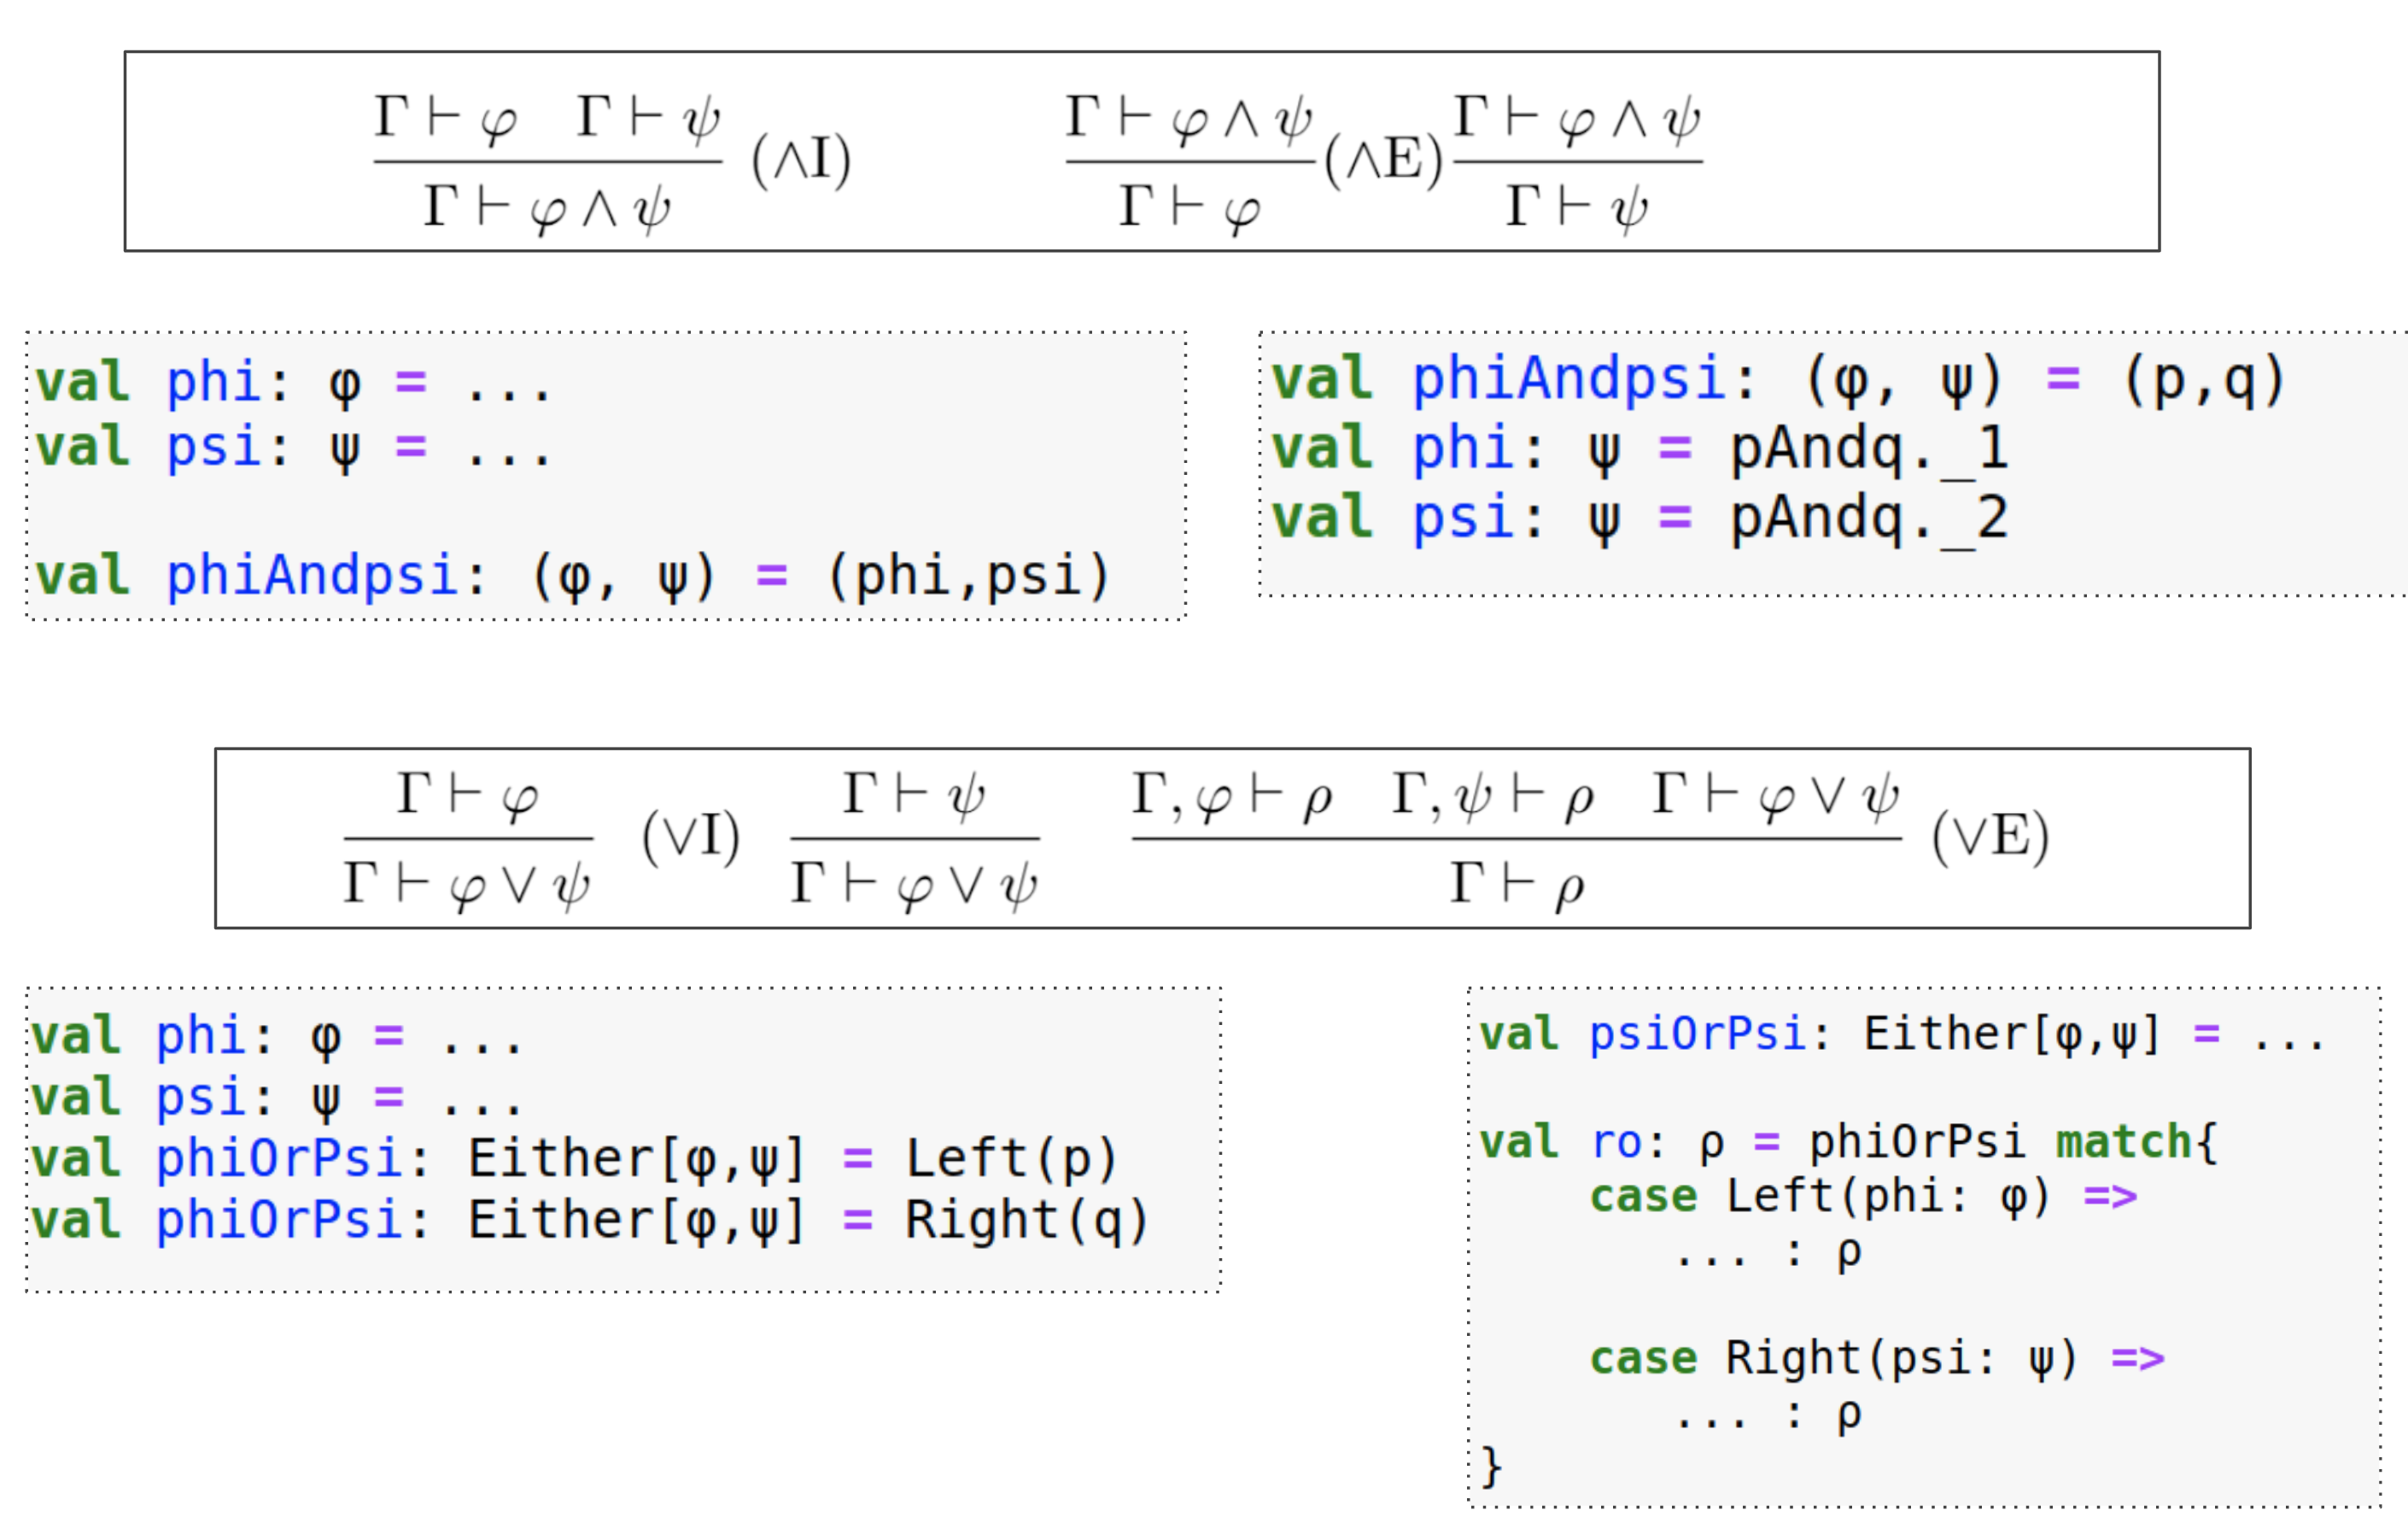

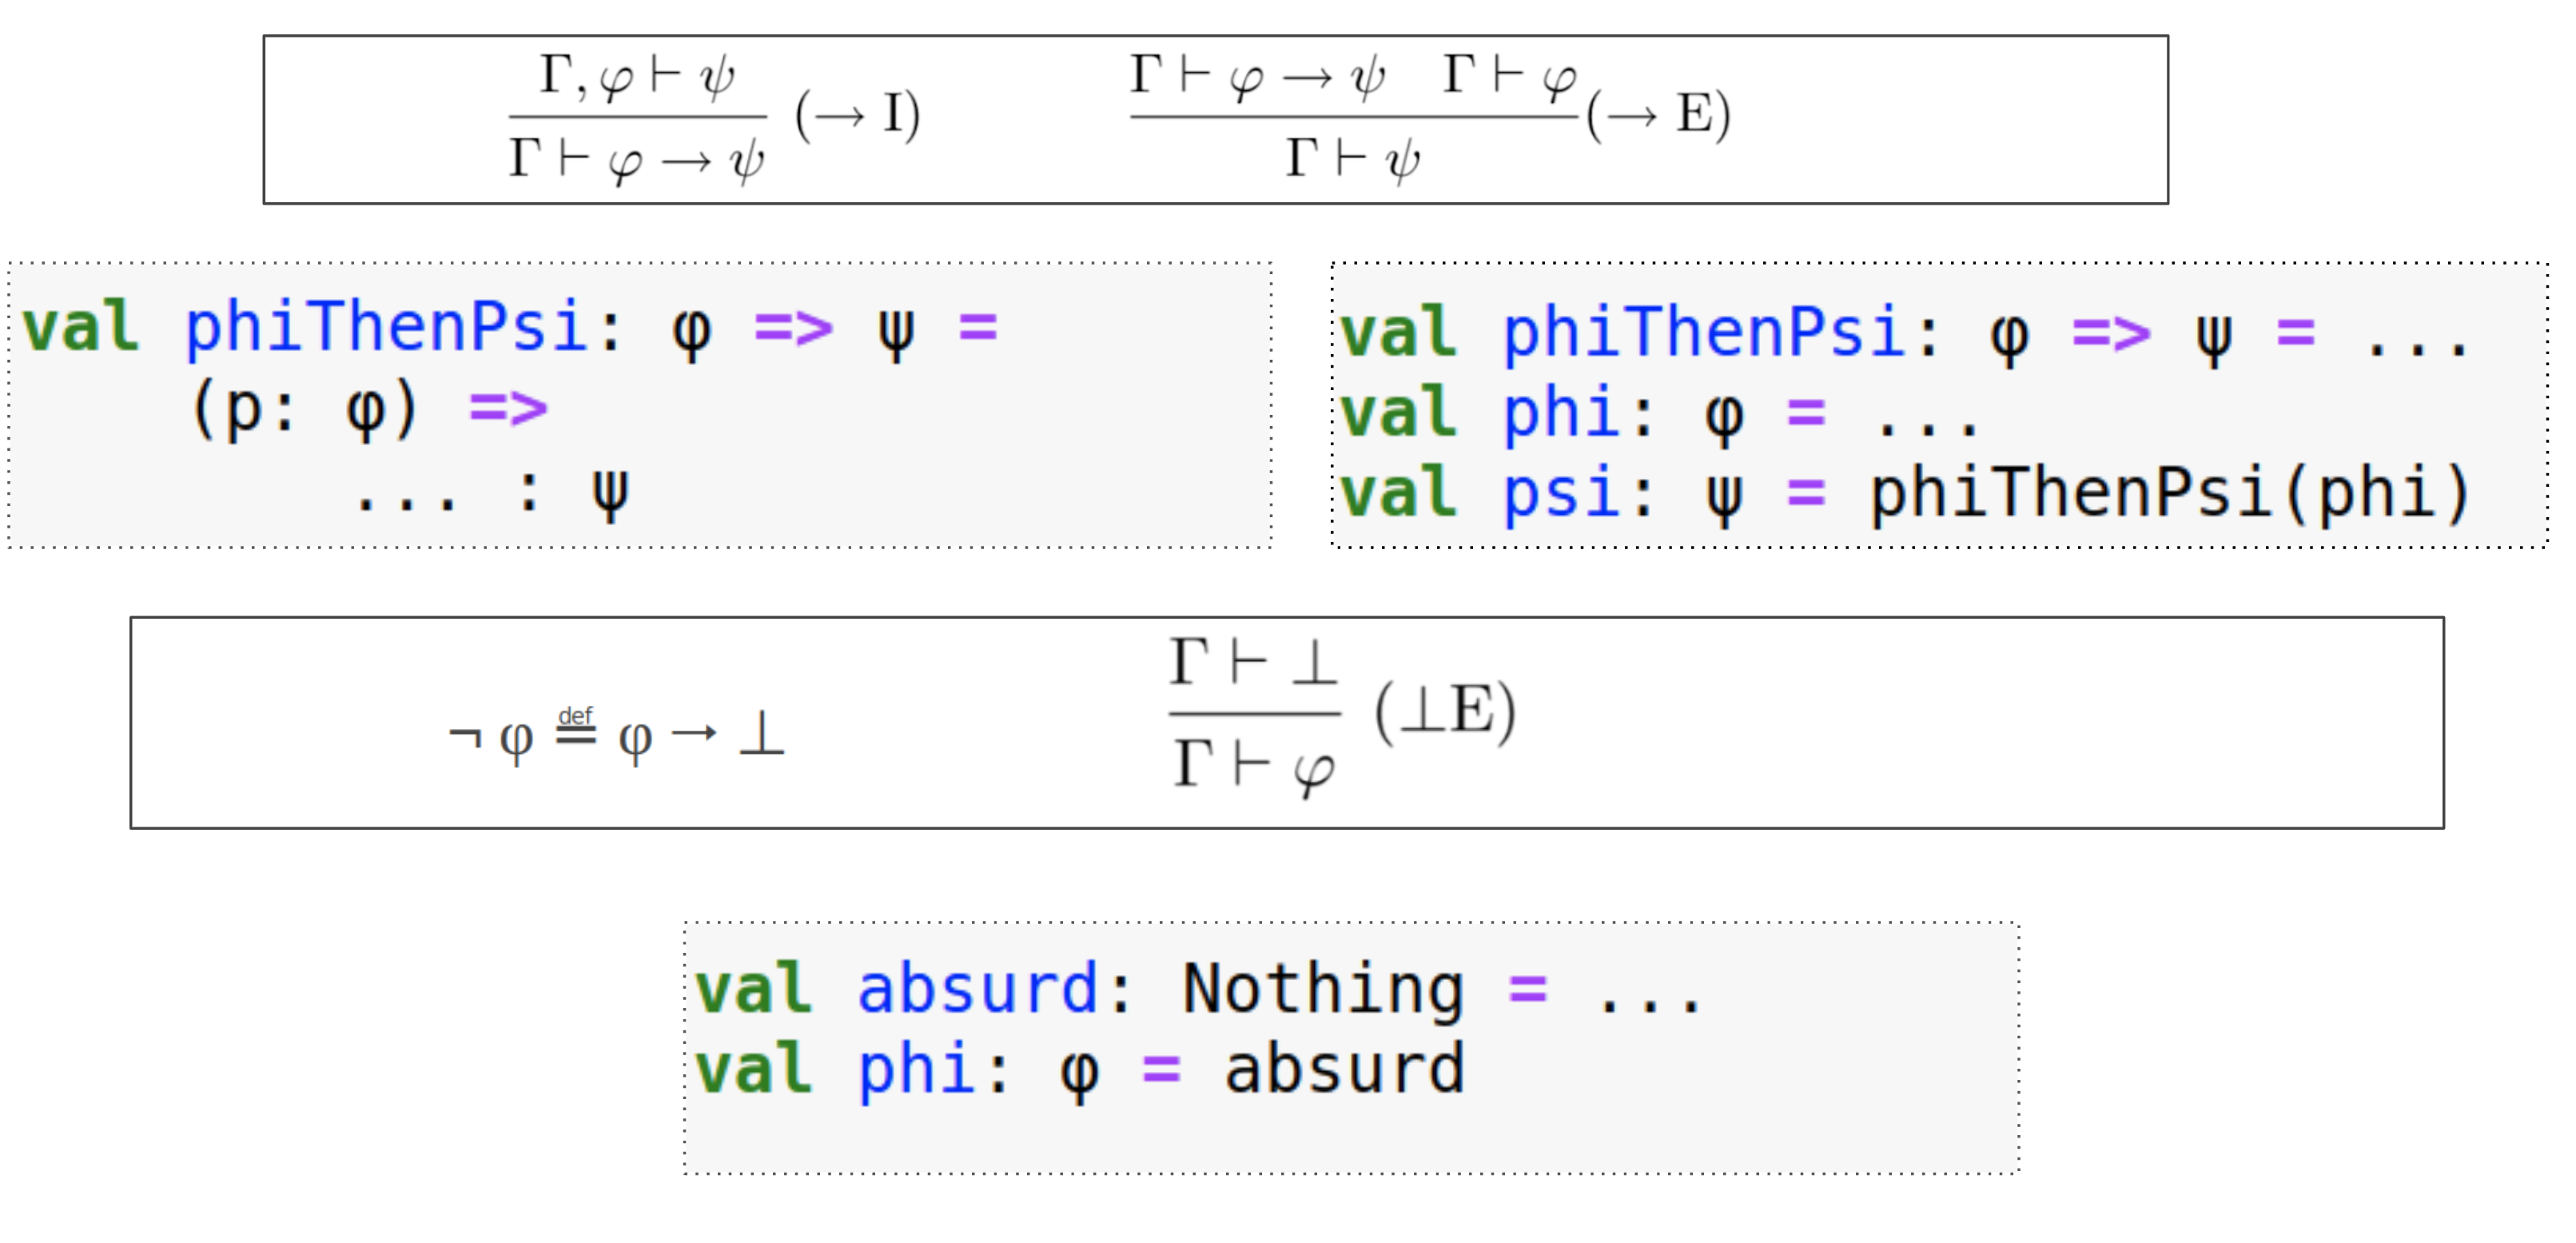

In order to emphasize this, let's reimplement our program in a more verbose way: 

In [ ]:
def program[P, Q, R]: ((P, Either[Q, R])) => Either[(P, Q), (P, R)] = 
    {`1`: (P, Either[Q,R])  =>                        // 1     p ∧ (q ∨ r) 
        val `1.1`: P = `1`._1                         // 1.1   p 
        val `1.2`: Either[Q, R] = `1`._2              // 1.2   q ∨ r 
        (`1.2` match {                                
            case Left(_1_3: Q) =>                     // 1.3   q
                val `1.3.1`: (P, Q) = (`1.1`,_1_3)    // 1.3.1 p ∧ q 
                Left(`1.3.1`)                         // 1.3.2 (p ∧ q) ∨ (p ∧ r)
            
            case Right(_1_4: R) =>                    // 1.4   r
                val `1.4.1`: (P, R) = (`1.1`, _1_4)   // 1.4.1 p ∧ r 
                Right(`1.4.1`)                        // 1.4.2 (p ∧ q) ∨ (p ∧ r)
            
        }): Either[(P,Q), (P,R)]                      // 1.5   (p ∧ q) ∨ (p ∧ r)
    }: (((P, Either[Q, R])) => Either[(P,Q), (P,R)])  // 2     p ∧ (q ∨ r) ⟶ (p ∧ q) ∨ (p ∧ r)

As we can see, conjunction behaves very much like products, in the sense that the introduction rule $\wedge.I$ corresponds to the product constructor `(_, _)`, and the elimination rule $\wedge.E$ to the selectors `_._1` and `_._2`. Similarly, the introduction rule for disjunction corresponds to the constructors of `Either`, i.e. `Left(_)` and `Right(_)`, and the elimination rule to pattern matching. Last, the introduction of an implication corresponds to the contruction of a lambda expression, and its elimination (not illustrated in the example), to function application. We can obtain an even more closer correspondence between the program and its corresponding proof with the following type aliases and definitions:

In [ ]:
object Ax{
    def apply[P](a: P): P = a
}

type ⟶[A, B] = A => B

object ⟶{
    def I[A, B](f: A => B): A ⟶ B =
        f
    
    def E[A, B](f: A ⟶ B)(a: A): B = 
        f(a)
}

type ⊥ = Nothing 

object ⊥{
    def E[A](a: ⊥): A = a
} 

type ∨[A, B] = Either[A, B]

object ∨{
    def IL[A, B](a: A): A ∨ B = Left(a)

    def IR[A, B](b: B): A ∨ B = Right(b)
    
    def E[A, B, C](f: A => C, g: B => C)(or: A ∨ B): C = 
        or match {
            case Left(a: A) => f(a)
            case Right(b: B) => g(b)
        }
}

type ∧[A, B] = (A, B)

object ∧{
    def I[A, B](a: A, b: B): A ∧ B = (a, b)
    
    def EL[A, B](and: A ∧ B): A = and._1
    
    def ER[A, B](and: A ∧ B): B = and._2
}

Together, they fully implement the introduction and ellimination rules of the natural deduction system introduced above. We can also add these aliases for negation and equivalence. 

In [ ]:
type ¬[A] = A ⟶ ⊥
type ⟷[A, B] = (A ⟶ B) ∧ (B ⟶ A)

The following aliases will also come in handy if we can't easily type unicode characters:

In [ ]:
type Absurd = ⊥
type Or[A, B] = ∨[A, B] 
type And[A, B] = ∧[A, B]
val Implies = ⟶
val Or = ∨ 
val And = ∧

Now, we can re-implement our program so that its correspondence with the natural deduction proof is more than apparent:

In [ ]:
def proof[P, Q, R]: (P ∧ (Q ∨ R)) ⟶ ((P ∧ Q) ∨ (P ∧ R)) = 
    ⟶.I{ `1`: P ∧ (Q ∨ R) =>                          // 1     p ∧ (q ∨ r) 
        val `1.1`: P = ∧.EL(`1`)                      // 1.1   p 
        val `1.2`: Q ∨ R = ∧.ER(`1`)                  // 1.2   q ∨ r 
        ∨.E(
            { `1.3`: Q =>                             // 1.3   q
              val `1.3.1`: P ∧ Q = ∧.I(`1.1`, `1.3`)  // 1.3.1 p ∧ q 
              ∨.IL(`1.3.1`)                           // 1.3.2 (p ∧ q) ∨ (p ∧ r)
            }, 
            { `1.4`: R =>                             // 1.4   r
              val `1.4.1`: P ∧ R = ∧.I(`1.1`, `1.4`)  // 1.4.1 p ∧ r 
              ∨.IR(`1.4.1`)                           // 1.4.2 (p ∧ q) ∨ (p ∧ r)
            })(
            `1.2`): (P ∧ Q) ∨ (P ∧ R)                 // 1.5   (p ∧ q) ∨ (p ∧ r)
    } : (P ∧ (Q ∨ R)) ⟶ ((P ∧ Q) ∨ (P ∧ R))           // 2     p ∧ (q ∨ r) ⟶ (p ∧ q) ∨ (p ∧ r)

# More examples

Let's see some more examples which show how to prove a theorem with a functional program.

# $\vdash (p \rightarrow q) \wedge p \rightarrow q$

In [ ]:
def program[P, Q]: (P => Q, P) => Q = 
    //(x, f) => f(x)
    _(_)

Believe it or not, the program above corresponds exactly to the following proof:

$$
\begin{array}{llr}
1 & (p \rightarrow q) \wedge p & premise \\
1.1 & p \rightarrow q & \wedge E(1) \\
1.2 & p  & \wedge E(1) \\
1.3 & q  & \rightarrow E(1.1,1.2) \\
2 & (p \rightarrow q) \wedge p \rightarrow q & \rightarrow I(1-1.3)
\end{array}
$$

as this re-implementation shows:

In [ ]:
def proof[P, Q]: (P ⟶ Q) ∧ P ⟶ Q = 
    ⟶.I{ `1`: (P ⟶ Q) ∧ P =>            // 1   (p ⟶ q) ∧ p
        val `1.1`: P ⟶ Q = ∧.EL(`1`)    // 1.1 p ⟶ q
        val `1.2`: P = ∧.ER(`1`)        // 1.2 p
        ⟶.E(`1.1`)(`1.2`): Q            // 1.3 q
    }: (P ⟶ Q) ∧ P ⟶ Q                  // 2   (p ⟶ q) ∧ p ⟶ q

# $\vdash p \vee q \rightarrow \neg p \rightarrow q$ 

In [ ]:
def proof[P, Q]: Either[P, Q] => (P => Nothing) => Q = 
    (e: Either[P, Q]) => 
        (f: P => Nothing) => 
            e match {
                case Left(a: P) => f(a): Q
                case Right(b: Q) => b : Q
            }

$$
\begin{array}{llr}
1 & p \vee q & \mathrm{premise} \\ 
1.1 & \neg p & \mathrm{premise} \\
&& \\
1.1.1 & p & \mathrm{premise} \\
1.1.1.1 & \bot & \rightarrow E(1.1,1.1.1) \\
1.1.1.2 & q & \bot E(1.1.1.1)\\
&& \\
1.1.2 & q & \mathrm{premise} \\
1.1.2.1 & q & \mathrm{Ax}(1.1.2) \\
&& \\
1.1.3 & q & \vee E(1.1.1-1.1.1.2,1.1.2-1.1.2.1,1)\\ 
1.2 & \neg p \rightarrow q & \rightarrow I(1.1-1.1.3)\\
2 & p \vee q \rightarrow \neg p \rightarrow q & \rightarrow I(1-1.2) 
\end{array}
$$

In [ ]:
def proof[P, Q]: P ∨ Q ⟶ (¬[P] ⟶ Q) = 
    ⟶.I{ `1`: P ∨ Q =>                                            // 1       p ∨ q
        ⟶.I{ `1.1`: ¬[P] =>                                       // 1.1     ¬p
            ∨.E(
                { `1.1.1`: P =>                                   // 1.1.1   p
                    val `1.1.1.1`: ⊥ = ⟶.E[P, ⊥](`1.1`)(`1.1.1`)  // 1.1.1.1 ⊥ 
                    ⊥.E(`1.1.1.1`): Q                             // 1.1.1.2 q
                },
                { `1.1.2`: Q =>                                   // 1.1.2   q   
                    Ax(`1.1.2`)                                   // 1.1.2.1 q
                })(
                `1`): Q                                           // 1.1.3   q
        }: ¬[P] ⟶ Q                                               // 1.2     ¬p ⟶ q
    }: P ∨ Q ⟶ (¬[P] ⟶ Q)                                         // 2       p ∨ q ⟶ ¬p ⟶ q

# $\vdash (p \rightarrow \neg q) \rightarrow (p \rightarrow q) \rightarrow \neg p$

In [ ]:
def proof3[P, Q]: (P => Not[Q]) => (P => Q) => Not[P] = 
    (a1: P => Not[Q]) => 
        (a2: P => Q) => 
            (a: P) => a1(a)(a2(a)) : Nothing

$$
\begin{array}{llr}
1 & p \rightarrow \neg q & premise \\
1.1 & p \rightarrow q & premise \\
1.1.1 & p & premise \\ 
1.1.1.1 & \neg q & \rightarrow E(1,1.1.1) \\
1.1.1.2 & q & \rightarrow E(1.1, 1.1.1) \\
1.1.1.3 & \bot & \rightarrow E(1.1.1.1,1.1.1.2) \\
1.1.2 & \neg p & \rightarrow I(1.1.1-1.1.1.3) \\
1.2 & (p \rightarrow q) \rightarrow \neg p & \rightarrow I(1.1-1.1.2)\\
2 & (p \rightarrow \neg q) \rightarrow (p \rightarrow q) \rightarrow \neg p & \rightarrow I(1-1.2)
\end{array}
$$

In [ ]:
def proof3[P, Q]: (P ⟶ ¬[Q]) ⟶ ((P ⟶ Q) ⟶ (¬[P])) = 
    ⟶.I{ `1`: (P ⟶ ¬[Q]) =>                             // 1        p ⟶ ¬q
        ⟶.I{ `1.1`: (P ⟶ Q) =>                          // 1.1      p ⟶ q
            ⟶.I[P,  ⊥]{ `1.1.1`: P =>                   // 1.1.1    p
                val `1.1.1.1`: ¬[Q] = ⟶.E(`1`)(`1.1.1`) // 1.1.1.1  ¬q
                val `1.1.1.2`: Q = ⟶.E(`1.1`)(`1.1.1`)  // 1.1.1.2  q
                ⟶.E[Q, ⊥](`1.1.1.1`)(`1.1.1.2`):  ⊥     // 1.1.1.3  ⊥
            }: ¬[P]                                     // 1.1.2    ¬p
        }: (P ⟶ Q) ⟶ ¬[P]                               // 1.2      (p ⟶ q) ⟶ ¬q
    }: (P ⟶ ¬[Q]) ⟶ ((P ⟶ Q) ⟶ ¬[P])                    // 2        (p ⟶ ¬q) ⟶ (p ⟶ q) ⟶ ¬q

# $\vdash (p \rightarrow q) \rightarrow (\neg q \rightarrow \neg p)$

In [ ]:
def program[P, Q]: (P => Q) => (Not[Q] => Not[P]) = 
    (ifpq: P => Q) => 
        (nq: (Q => Absurd)) => 
            (p: P) => 
                 nq(ifpq(p)): Absurd

$$
\begin{array}{llr}
1 & p \rightarrow q  &  premise \\
1.1 & \neg q & premise \\
1.1.1 & p & premise \\ 
1.1.1.1 & q & \rightarrow E(1,1.1.1) \\
1.1.1.2 & \bot & \rightarrow E(1.1, 1.1.1.1) \\
1.1.2 & \neg p & \rightarrow I(1.1.1-1.1.1.2) \\
1.2 & \neg q \rightarrow \neg p & \rightarrow I(1.1-1.1.2)\\
2 & (p \rightarrow q) \rightarrow (\neg q \rightarrow \neg p) & \rightarrow I(1-1.2)
\end{array}
$$

In [ ]:
def proof[P, Q]: (P ⟶ Q) ⟶ (¬[Q] ⟶ ¬[P]) = 
    ⟶.I{ `1`: P ⟶ Q =>                                // 1 p ⟶ q
        ⟶.I{ `1.1`: (Q ⟶ Absurd) =>                   // 1.1 ¬q 
            ⟶.I{ `1.1.1`: P =>                        // 1.1.1 p
                val `1.1.1.1`: Q = ⟶.E(`1`)(`1.1.1`)  // 1.1.1.1 q
                ⟶.E(`1.1`)(`1.1.1.1`): ⊥              // 1.1.1.2 ⊥
            }: ¬[P]                                   // 1.1.2 ¬p
        }: (¬[Q] ⟶ ¬[P])                              // 1.2 ¬q ⟶ ¬p        
    }: (P ⟶ Q) ⟶ (¬[Q] ⟶ ¬[P])                        // 2 (p ⟶ q) ⟶ (¬q ⟶ ¬p)

The previous examples were all positive ones: if we have a theorem, then we can implement the corresponding function. The opposite also works: if some proposition is not a theorem, then we won't be able to implement that function, no matter how hard we try.

# The intuitionistic stance

But, what about the following theorem? 

# $\vdash \neg (p \wedge q) \rightarrow \neg p \vee \neg q$

In [ ]:
def program[P, Q]: Not[(P, Q)] => Either[Not[P], Not[Q]] = 
    { `1`: (((P, Q)) => Nothing) => 
        // Left((p: P) => `1`((p : P, ??? : Q)) : Nothing)
        Right((q: Q) => `1`((??? : P, q : Q)) : Nothing)
    }

No matter how hard we try, we get stuck, i.e. we can't complete an implementation of that function. And yet, the proposition is a theorem of logic ... or is it not? Well, it depends on the _kind_ of logic we are talking about: indeed, that formula is a theorem of _classical_ logic, but it's is not a theorem of _intuitionistic_ logic. And the kind of logic which actually corresponds to the kind of functional programming we are doing is _intuitionistic propositional logic_. This logic is characterised by a different mode of reasoning: in classical logic, our reasoning revolves around _truth_, whereas in intuitionistic logic our reasoning revolves around _proofs_. For instance, the formula above can be read as follows:

* If p and q is false, then p is false or q is false (the classical reading)

* If we can prove absurdity given a proof of p and a proof of q, then we can prove absurdity given either a proof of p alone, or a proof of q alone (the intuitionistic reading)

Clasically, it makes sense; intuitionistically, the premise does not support the conclusion at all. The same happens with other formulas, most notably, the double negation theorem and the law of the third middle: 

# $\vdash \neg \neg p \rightarrow p$

In [ ]:
def program[P]: Not[Not[P]] => P = 
    { n : ((P => Nothing) => Nothing) => 
        ??? : P 
    }

In this case, the premise asserts that we can reach a contradiction (proving the absurd) if we asume that p can't be proved; but that does not mean that we can construct an actual proof of $p$ at all!

# $\vdash p \vee \neg p$

In [ ]:
def program[P]: Either[P, Not[P]] = 
    ??? 
    // Left(??? : P)
    // Right((p: P) => ??? : Nothing)

"Given any proposition $p$, we can construct a proof of $p$ or show that a proof of $p$ leads to contradiction" ... Come off it!

These two formulas are important, since we can obtain the expressiveness of classical logic if we assume one of them as premise. For instance:

In [ ]:
def program[P, Q](thirdMiddleP: Either[P, Not[P]]): Not[(P, Q)] => Either[Not[P], Not[Q]] = 
    { `1`: (((P, Q)) => Nothing) => 
        thirdMiddleP match {
            case Left(p: P) => 
                Right((q: Q) => `1`((p : P, q : Q)) : Nothing)
            case Right(np: Not[P]) => 
                Left((p: P) => np(p) : Nothing)
        }
    }


# Conclusion


The correspondence between intuitionistic propositional logic and computation that we have just seen is awesome. But it goes even further, since it pervades the whole spectrum of logics: first-order logic, modal logics, higher-order logic, etc., have also their computational counterparts in terms of different types of functional languages: dependently-typed programming languages correspond to (intuitionistic) first-order logics, monadic programming to a particular kind of modal logic; generic programming to higher-order logic; etc. Right now, the computation landscape is plagued with programming languages in which this correspondence between logic and computational is not apparent, but the time will come when programming practice will be, in essence, pure logic! Be ready for that ;)